In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from typing import List, Dict
from itertools import combinations
from scipy.stats import ttest_ind

In [2]:
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

stud = pd.read_csv('stud_math.csv')

In [3]:
display(stud.head(10))

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


In [4]:
stud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

# Функции

In [5]:
# Удаление пустых ячеек из колонок.
def empty_values_replace(column: pd.Series):
    column.replace("", np.nan, inplace=True)

In [6]:
# форматирование имён колонок (с маленькой буквы), чтобы к ним удобно было обращаться как к объектам
def column_names_formatter(columns) -> List[str]:
    columns = list(columns)
    for i in range(len(columns)):
        columns[i] = columns[i].lower()
    return columns 

In [7]:
# по итогам вебинара с наставником функция пока не нужна, но может пригодиться в дальнейшем
# изменение строковых значений в столбцах на числовые (напр. "yes" и "no" заменяются на 1 и 0)
def str_to_int(column: pd.Series, old_and_new_values: Dict[str, int]) -> pd.Series:
    """
    column - колонка для изменений
    old_and_new_values - словарь, где: 
    ключи - текущие значения ячеек в колонке,
    значения - значения ячеек, которые будут установлены.
    """
    keys = list(old_and_new_values.keys())
    values = list(old_and_new_values.values())
    for i in range(len(old_and_new_values)):
        column = column.replace(keys[i], values[i])
    return column

In [8]:
# подведение статистики по верхним и нижним границам боксплота. также подсчёт 1 и 3 квартилей
def boxplot_stat(column: pd.Series):
    perc25 = column.quantile(0.25)
    perc75 = column.quantile(0.75)
    IQR = perc75 - perc25
    print(f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR}. Границы выбросов: [{perc25 - 1.5*IQR}, {perc75 + 1.5*IQR}]')

In [9]:
# Проверим нулевую гипотезу о том, что распределения оценок батончиков по различным параметрам неразличимы:
def get_stat_dif(column):
    cols = stud.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud.loc[stud.loc[:, column] == comb[0], 'score'], 
                        stud.loc[stud.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

# Предобработка данных

In [10]:
for column in stud.columns:
    empty_values_replace(column=stud[column])

In [11]:
"""
В данных есть повторяющиеся колонки "studytime" и "studytime, granular". Убедимся, что данные идентичны
"""
print(stud.studytime.corr(stud["studytime, granular"]))

-1.0


In [12]:
# коэффициент корреляции -1 -> данные идентичны полностью, вплоть до пропусков
# в колонке "studytime, granular" данные отрицательные, что менее читаемо. её можно удалить
stud.drop(["studytime, granular"], inplace=True, axis=1)

In [13]:
stud.columns = column_names_formatter(stud.columns)

In [14]:
# как писал при объявлении функции str_to_int, на данном этапе она пока не нужна

# yes_no_replacer = {
#     "yes": 1,
#     "no": 0
# }
# for i in range(15, 23):
#     print(stud.columns[i])
#     stud[stud.columns[i]] = str_to_int(stud[stud.columns[i]], yes_no_replacer)

In [15]:
one_value_cols = [col for col in stud.columns if stud[col].nunique() <= 1]
print(f'В данных {len(one_value_cols)} колонок с 1 уникальным значением.')

В данных 0 колонок с 1 уникальным значением.


In [16]:
# в колонке score 6 пустых ячеек, для обучения модели эти строки вряд ли пригодятся
stud.dropna(axis=0, how="any", subset=["score"], inplace=True)

In [17]:
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      389 non-null    object 
 1   sex         389 non-null    object 
 2   age         389 non-null    int64  
 3   address     374 non-null    object 
 4   famsize     362 non-null    object 
 5   pstatus     344 non-null    object 
 6   medu        386 non-null    float64
 7   fedu        365 non-null    float64
 8   mjob        370 non-null    object 
 9   fjob        353 non-null    object 
 10  reason      372 non-null    object 
 11  guardian    358 non-null    object 
 12  traveltime  361 non-null    float64
 13  studytime   382 non-null    float64
 14  failures    367 non-null    float64
 15  schoolsup   380 non-null    object 
 16  famsup      351 non-null    object 
 17  paid        350 non-null    object 
 18  activities  375 non-null    object 
 19  nursery     374 non-null    o

# Анализ данных

## Обработка колонок

### school

In [18]:
pd.DataFrame(stud.school.value_counts(dropna=False))

,school
GP,344
MS,45


### sex

In [19]:
pd.DataFrame(stud.sex.value_counts(dropna=False))

,sex
F,204
M,185


### age

In [20]:
pd.DataFrame(stud.age.value_counts(dropna=False))

,age
16,103
17,98
15,82
18,80
19,21
20,3
22,1
21,1


<AxesSubplot:>

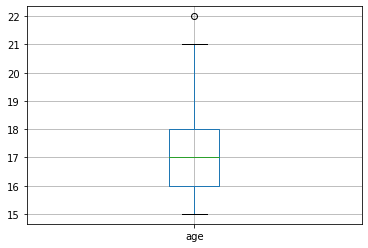

In [21]:
stud.boxplot(['age'])

In [22]:
# в данных имеются выбросы. возраст школьников старше 18 в принципе вызывает подозрение. 
# но т.к. 22 за пределами boxplot,пока удаляем только его
stud = stud.loc[stud.age <= 21]

<AxesSubplot:>

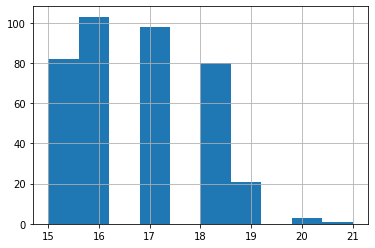

In [23]:
stud.age.hist()

### address — тип адреса ученика ('U' - городской, 'R' - за городом)

In [24]:
stud.address.value_counts(dropna=False, normalize=True)

U      0.747423
R      0.213918
NaN    0.038660
Name: address, dtype: float64

In [25]:
# гипотеза: ученики за городом добираются больше 45 минут. можно попытаться восполнить пропуск в данных 
# на этом основании. для начала проверим гипотезу
GP_stud = stud[stud.school == "GP"]

# вывод учеников из школы GP, которые добираются 45 минут и дольше
print(GP_stud.address[GP_stud.traveltime >= 3].value_counts(dropna=False))

# вывод учеников из школы GP, которые добираются 15 минут и меньше
print(GP_stud.address[GP_stud.traveltime == 1].value_counts(dropna=False))

U    12
R     8
Name: address, dtype: int64
U      189
R       29
NaN      7
Name: address, dtype: int64


как видно, ученики GP могут находиться за городом и добираться менее 15 минут. 
также они могут быть в городе и добираться больше 45 минут. вероятно, школа на окраине города.

In [26]:
MS_stud = stud[stud.school == "MS"]
print(MS_stud.address[MS_stud.traveltime >= 3].value_counts(dropna=False))
print(MS_stud.address[MS_stud.traveltime == 1].value_counts(dropna=False))

R    8
Name: address, dtype: int64
U    8
R    5
Name: address, dtype: int64


гипотеза не подтвердилась, т.к. школьники обеих школ за пределами города могут добраться до неё менее чем за 15 минут.

### famsize — размер семьи('LE3' <= 3, 'GT3' >3)

In [27]:
stud.famsize.value_counts(dropna=False, normalize=True)

GT3    0.654639
LE3    0.275773
NaN    0.069588
Name: famsize, dtype: float64

In [28]:
# в столбце есть около 7% пропущенных значений. пока оставим как есть

### pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

In [29]:
stud.pstatus.value_counts(dropna=False, normalize=True)

T      0.791237
NaN    0.115979
A      0.092784
Name: pstatus, dtype: float64

в столбце есть около 11% пропущенных значений. пока оставим как есть

In [30]:
stud[stud.famrel <= 2].pstatus.value_counts(dropna=False)

T      18
A       4
NaN     3
Name: pstatus, dtype: int64

### medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [31]:
stud.medu.value_counts(dropna=False, normalize=True)

4.0    0.337629
2.0    0.257732
3.0    0.244845
1.0    0.144330
0.0    0.007732
NaN    0.007732
Name: medu, dtype: float64

<AxesSubplot:>

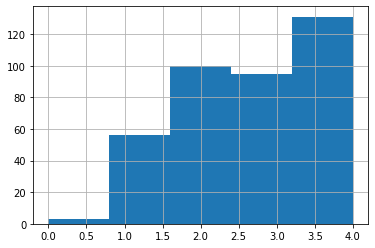

In [32]:
stud.medu.hist(bins=5)

в столбце менее 1% пропущенных значений. пока оставим как есть

### fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [33]:
stud.fedu.value_counts(dropna=False, normalize=True)

2.0     0.270619
3.0     0.242268
4.0     0.226804
1.0     0.190722
NaN     0.061856
0.0     0.005155
40.0    0.002577
Name: fedu, dtype: float64

In [34]:
# вероятнее всего вместо 4 поставили 40 по невнимательности. уберём ошибку
stud.fedu = stud.fedu.apply(lambda x: float(str(x).replace('40', '4')))

In [35]:
stud.fedu.value_counts(dropna=False, normalize=True)

2.0    0.270619
3.0    0.242268
4.0    0.229381
1.0    0.190722
NaN    0.061856
0.0    0.005155
Name: fedu, dtype: float64

<AxesSubplot:>

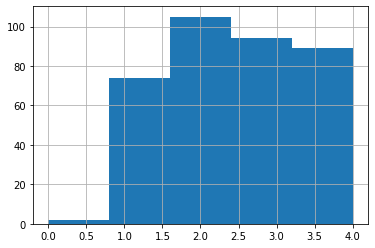

In [36]:
stud.fedu.hist(bins=5)

<AxesSubplot:>

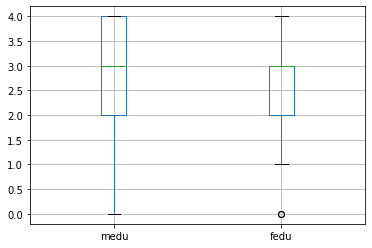

In [37]:
stud.boxplot(['medu', 'fedu'])

отец без образования попал в значение выбросов. но в реальной жизни встречаются родители без образования, поэтому данные не удаляем

в столбце около 6% пропущенных значений. пока оставим всё как есть

### mjob - работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [38]:
stud.mjob.value_counts(dropna=False, normalize=True)

other       0.327320
services    0.250000
at_home     0.149485
teacher     0.141753
health      0.082474
NaN         0.048969
Name: mjob, dtype: float64

в столбце около 5% пропущенных значений. пока оставим как есть

### fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [39]:
stud.fjob.value_counts(dropna=False, normalize=True)

other       0.500000
services    0.252577
NaN         0.092784
teacher     0.074742
at_home     0.041237
health      0.038660
Name: fjob, dtype: float64

в столбце около 9% пропущенных значений. пока оставим как есть

### reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

In [40]:
stud.reason.value_counts(dropna=False, normalize=True)

course        0.347938
reputation    0.262887
home          0.260309
other         0.085052
NaN           0.043814
Name: reason, dtype: float64

в столбце около 4% пропущенных значений. пока оставим как есть

### guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

In [41]:
stud.guardian.value_counts(dropna=False, normalize=True)

mother    0.636598
father    0.221649
NaN       0.079897
other     0.061856
Name: guardian, dtype: float64

в столбце около 8% пропущенных значений. пока оставим как есть

### traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

In [42]:
stud.traveltime.value_counts(dropna=False, normalize=True)

1.0    0.613402
2.0    0.242268
NaN    0.072165
3.0    0.054124
4.0    0.018041
Name: traveltime, dtype: float64

<AxesSubplot:>

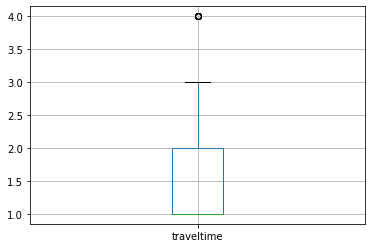

In [43]:
stud.boxplot(['traveltime'])

учеников из дальних районов настолько мало, что они попали в зону выбросов. однако в жизни такие случаи встречаются, поэтому данные не удаляем.

в столбце около 7% пропущенных значений. пока оставим как есть

### studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

In [44]:
stud.studytime.value_counts(dropna=False, normalize=True)

2.0    0.487113
1.0    0.262887
3.0    0.162371
4.0    0.069588
NaN    0.018041
Name: studytime, dtype: float64

в столбце около 2% пропущенных значений. пока оставим как есть

### failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

In [45]:
stud.failures.value_counts(dropna=False, normalize=True)

0.0    0.747423
1.0    0.123711
NaN    0.056701
2.0    0.038660
3.0    0.033505
Name: failures, dtype: float64

<AxesSubplot:>

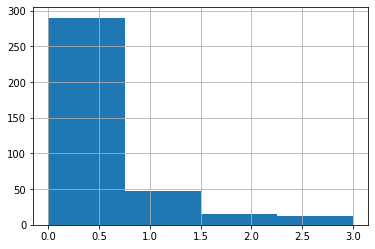

In [46]:
stud.failures.hist(bins=4)

в столбце около 6% пропущенных значений. пока оставим как есть
в целом непонятна формулировка столбца, т.к. внеучебная неудача - слишком широкое поле возможных событий в жизни ученика.

### schoolsup — дополнительная образовательная поддержка (yes (1) или no(0))

In [47]:
stud.schoolsup.value_counts(dropna=False, normalize=True)

no     0.850515
yes    0.126289
NaN    0.023196
Name: schoolsup, dtype: float64

в столбце около 2% пропущенных значений. пока оставим как есть

### famsup — семейная образовательная поддержка (yes(1) или no(0))

In [48]:
stud.famsup.value_counts(dropna=False, normalize=True)

yes    0.556701
no     0.345361
NaN    0.097938
Name: famsup, dtype: float64

в столбце около 10% пропущенных значений. пока оставим как есть

### paid — дополнительные платные занятия по математике (yes(1) или no(0))

In [49]:
stud.paid.value_counts(dropna=False, normalize=True)

no     0.505155
yes    0.394330
NaN    0.100515
Name: paid, dtype: float64

в столбце около 10% пропущенных значений. пока оставим как есть

### activities — дополнительные внеучебные занятия (yes(1) или no(0))

In [50]:
stud.activities.value_counts(dropna=False, normalize=True)

yes    0.494845
no     0.469072
NaN    0.036082
Name: activities, dtype: float64

в столбце около 4% пропущенных значений. пока оставим как есть

### nursery — посещал детский сад (yes(1) или no(0))

In [51]:
stud.nursery.value_counts(dropna=False, normalize=True)

yes    0.765464
no     0.195876
NaN    0.038660
Name: nursery, dtype: float64

в столбце около 4% пропущенных значений. пока оставим как есть

### higher — хочет получить высшее образование (yes или no)

In [52]:
stud.higher.value_counts(dropna=False, normalize=True)

yes    0.902062
NaN    0.051546
no     0.046392
Name: higher, dtype: float64

в столбце около 5% пропущенных значений. пока оставим как есть
также тут явный перевес в пользу значения yes, но выводы о столбце сделаем после корреляции и ttest

### internet — наличие интернета дома (yes или no)

In [53]:
stud.internet.value_counts(dropna=False, normalize=True)

yes    0.770619
no     0.141753
NaN    0.087629
Name: internet, dtype: float64

в столбце около 9% пропущенных значений. пока оставим как есть

### romantic — в романтических отношениях (yes или no)

In [54]:
stud.romantic.value_counts(dropna=False, normalize=True)

no     0.605670
yes    0.314433
NaN    0.079897
Name: romantic, dtype: float64

в столбце около 8% пропущенных значений. пока оставим как есть

### famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

In [55]:
stud.famrel.value_counts(dropna=False, normalize=True)

 4.0    0.458763
 5.0    0.247423
 3.0    0.159794
 NaN    0.069588
 2.0    0.043814
 1.0    0.018041
-1.0    0.002577
Name: famrel, dtype: float64

In [56]:
# заменим отрицательное значение на положительное. т.к. вероятно это опечатка
stud.famrel = stud.famrel.apply(lambda x: float(str(x).replace('-', '')))

в столбце около 7% пропущенных значений. пока оставим как есть

### freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

In [57]:
stud.freetime.value_counts(dropna=False, normalize=True)

3.0    0.391753
4.0    0.280928
2.0    0.162371
5.0    0.095361
1.0    0.046392
NaN    0.023196
Name: freetime, dtype: float64

в столбце около 2% пропущенных значений. пока оставим как есть

### goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

In [58]:
stud.goout.value_counts(dropna=False, normalize=True)

3.0    0.324742
2.0    0.260309
4.0    0.208763
5.0    0.128866
1.0    0.059278
NaN    0.018041
Name: goout, dtype: float64

в столбце около 2% пропущенных значений. пока оставим как есть

### health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

In [59]:
stud.health.value_counts(dropna=False, normalize=True)

5.0    0.353093
3.0    0.226804
4.0    0.154639
1.0    0.118557
2.0    0.108247
NaN    0.038660
Name: health, dtype: float64

в столбце около 4% пропущенных значений. пока оставим как есть

### absences — количество пропущенных занятий

In [60]:
stud.absences.value_counts(dropna=False, normalize=True)

0.0      0.283505
2.0      0.154639
4.0      0.134021
6.0      0.077320
8.0      0.051546
10.0     0.043814
12.0     0.030928
14.0     0.030928
NaN      0.028351
3.0      0.018041
16.0     0.015464
7.0      0.015464
5.0      0.012887
18.0     0.012887
20.0     0.010309
1.0      0.007732
22.0     0.007732
9.0      0.007732
13.0     0.005155
15.0     0.005155
11.0     0.005155
25.0     0.002577
54.0     0.002577
385.0    0.002577
26.0     0.002577
56.0     0.002577
24.0     0.002577
212.0    0.002577
21.0     0.002577
75.0     0.002577
30.0     0.002577
19.0     0.002577
38.0     0.002577
40.0     0.002577
23.0     0.002577
17.0     0.002577
28.0     0.002577
Name: absences, dtype: float64

In [61]:
boxplot_stat(stud.absences)

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0. Границы выбросов: [-12.0, 20.0]


In [62]:
# верхняя граница выбросов - 20. но здравый смысл подсказывает, что 20 дней слишком мало для тех, 
# кто прогуливает часто. в году максимально 222 учебных дня (согласно википедии), 
# поэтому возьмём границу в 100 дней.
stud = stud.loc[stud.absences <= 100]

### score - итоговая оценка

In [63]:
stud.score.value_counts(dropna=False)

50.0     53
55.0     46
0.0      36
75.0     31
65.0     31
60.0     29
40.0     28
70.0     27
45.0     26
80.0     16
30.0     15
90.0     11
35.0      9
25.0      7
95.0      5
85.0      3
100.0     1
20.0      1
Name: score, dtype: int64

In [64]:
boxplot_stat(stud.score)

25-й перцентиль: 40.0, 75-й перцентиль: 67.5, IQR: 27.5. Границы выбросов: [-1.25, 108.75]


<AxesSubplot:>

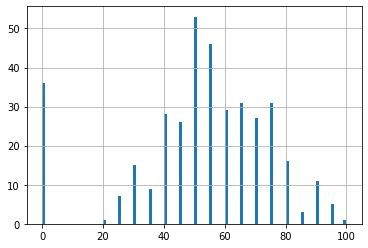

In [65]:
stud.score.hist(bins=100)

примерно 10% учеников написали тест на 0 баллов - возможно, они просто не пришли на экзамен. 
здравый смысл подсказывает, что эти оценки учитывать не нужно, т.к. это скорее задача классификации - придёт студент на экзамен или нет.

In [66]:
stud = stud.loc[stud.score > 0]

## Корреляционный анализ

In [67]:
stud.corr()

,age,medu,fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.129564,-0.113178,0.107269,0.016386,0.171353,0.040026,-0.019464,0.091906,-0.034229,0.202315,-0.115957
medu,-0.129564,1.000000,0.617855,-0.178185,0.062499,-0.210275,-0.008462,0.007528,0.065632,-0.050390,0.073565,0.184005
fedu,-0.113178,0.617855,1.000000,-0.146715,-0.030213,-0.257937,-0.006240,-0.029863,0.040835,0.007333,0.035339,0.122835
traveltime,0.107269,-0.178185,-0.146715,1.000000,-0.106488,0.108927,-0.031418,-0.013535,0.025518,0.009073,-0.005571,-0.081282
studytime,0.016386,0.062499,-0.030213,-0.106488,1.000000,-0.142251,0.062976,-0.128704,-0.023949,-0.098541,-0.074331,0.138009
failures,0.171353,-0.210275,-0.257937,0.108927,-0.142251,1.000000,-0.024023,0.113270,0.106662,0.089202,0.125029,-0.275894
famrel,0.040026,-0.008462,-0.006240,-0.031418,0.062976,-0.024023,1.000000,0.155857,0.029873,0.111629,-0.068296,0.071034
freetime,-0.019464,0.007528,-0.029863,-0.013535,-0.128704,0.113270,0.155857,1.000000,0.294461,0.061142,-0.084837,-0.012817
goout,0.091906,0.065632,0.040835,0.025518,-0.023949,0.106662,0.029873,0.294461,1.000000,0.012348,0.038765,-0.198438
health,-0.034229,-0.050390,0.007333,0.009073,-0.098541,0.089202,0.111629,0.061142,0.012348,1.000000,-0.010451,-0.062086


все числовые столбцы показывают наличие корреляции. по модулю значения ниже 0,06 только у колонки freetime

In [68]:
# проверим на статистическую значимость относитльно колонки score все остальные колонки
for col in stud.columns[:-1]:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки age
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки medu
Найдены статистически значимые различия для колонки mjob
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки goout


Итак, в нашем случае важные переменные, которые, возможно, оказывают влияние на оценку, это: sex, age, address, medu, mjob, studytime, failures, schoolsup, goout
Также здравый смысл подсказывает, что нужно включить колонки:
- fedu и fjob, т.к. есть аналогичные колонки у мам. оба родителя могут повлиять на образование ребёнка
- paid - т.к. занятия с репетитором могут влиять на оценку по экзамену.
- absences - пропуски учёбы также негативно влияют на учёбу ученика, поэтому не хотелось бы исключать эти данные.

In [69]:

stud_for_model = stud.loc[:, ["sex", "age", "address", "medu", "mjob", "fedu", "fjob", 
                              "paid", "studytime", "failures", "schoolsup", "goout", "absences"]]

# Выводы

Итак, в результате EDA для анализа влияния информации об ученике на его итоговый экзамен по математике были получены выводы:
- В данных достаточно много пустых значений (5-10%). Пропущенные ячейки стоят вразнобой. Если удалить все строки с пропущенными значениями, то теряется примерно половина датасета.
- Из количественных переменных есть только переменная с пропусками учебных дней у учеников. В ней есть выбросы. Все остальные переменные либо бинарные, либо категориальные.
- Самый важные данные, которые будут использованы в дальнейшем: "sex", "age", "address", "medu", "mjob", "fedu", "fjob", "paid", "studytime", "failures", "schoolsup", "goout", "absences"
- Во многих категориальных переменных есть выбросы. Убирать их нет смысла, т.к. это не реальные выбросы, просто участники, которые выбирали эту категорию оказались в меньшинстве.